In [90]:
''' required import '''

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

In [91]:
''' noise reducer '''

def noiseReducer(img):
    img = np.array(img)
    img = cv2.GaussianBlur(img, (7, 7), 0)
    img = Image.fromarray(img, 'RGB')
    return img

In [92]:
''' book spine processing '''


' book spine processing '

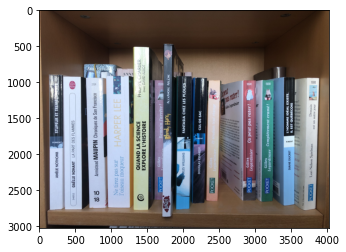

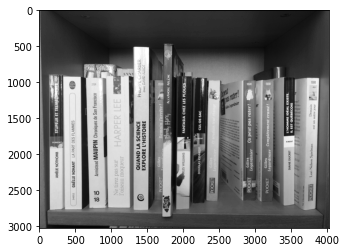

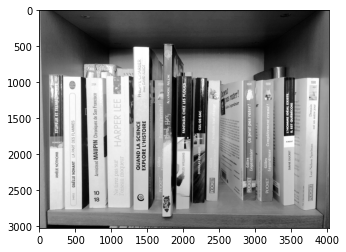

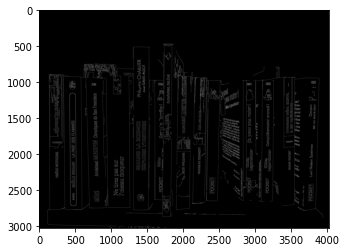

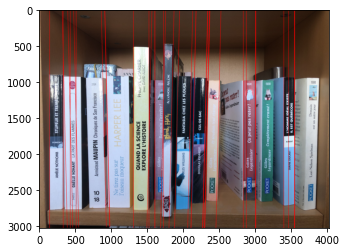

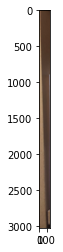

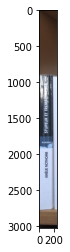

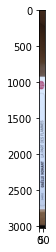

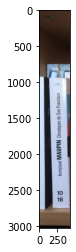

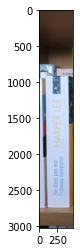

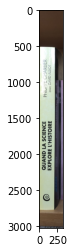

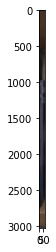

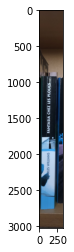

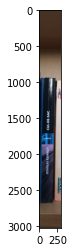

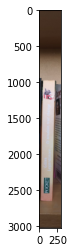

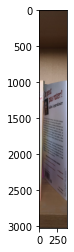

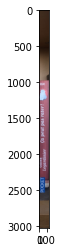

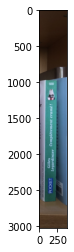

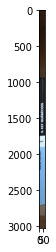

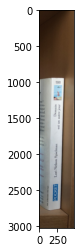

In [93]:
''' row segmentation '''

# constraint : doesn't work with thin book spines and horizontal books

# image load
img = Image.open('../image/img15.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img)

"""
img : image of a row
return : list of book spines
"""
def rowSegmentation(img):
    
    width, height = img.size
    img = np.array(img)
    
    # gray converter
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')
    plt.show()
    
    # histogram equalizer
    gray = cv2.equalizeHist(gray)
    plt.imshow(gray, cmap='gray')
    plt.show()

    # canny filter
    edges = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(edges, 50, 150)
    plt.imshow(edges, cmap='gray')
    plt.show()  

    # hough transform
    threshold = 300
    coordinate = []
    houghTransform = img.copy()
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)
    for line in lines:
        coordinate.append((0,0))
        for rho,theta in line:
            if theta<np.pi/2-0.2 or np.pi/2+0.2<theta:
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + width*(-b))
                y1 = int(y0 + height*(a))
                x2 = int(x0 - width*(-b))
                y2 = int(y0 - height*(a))
                houghTransform = cv2.line(houghTransform, (x1,y1), (x2,y2), (255,0,0), 3)
                coordinate.append((x1,x2))
        coordinate.append((width,width))
    plt.imshow(houghTransform)
    plt.show()
    
    # segmentation
    croppedImg = []
    coordinate.sort()
    img = Image.fromarray(img, 'RGB')
    last = None
    threshold = width/50
    for x1,x2 in coordinate:
        if (last != None and last<min(x1,x2)-threshold):
            croppedImg.append(img.crop((last, 0, max(x1,x2), height)))
        last = min(x1,x2)
    
    return croppedImg

# show result
images = rowSegmentation(img)
for im in images:
    plt.imshow(im)
    plt.show()

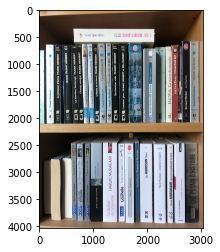

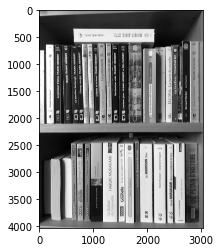

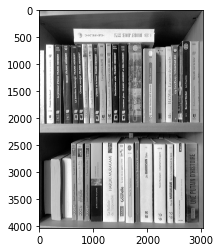

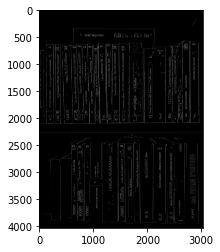

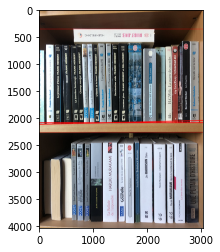

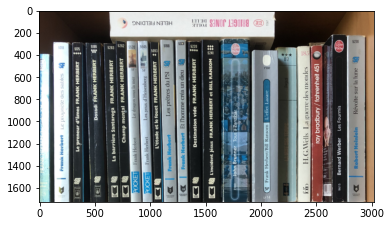

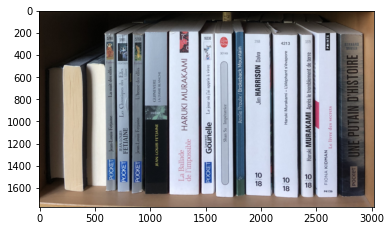

In [94]:
''' bookshelf segmentation '''

# constraint : doesn't work with thin book spines and low definition image

# image load
img = Image.open('../image/img16.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img)


"""
img : image of a vertical bookshelf
return : list of book rows
"""
def bookshelfSegmentation(img):
    
    width, height = img.size
    img = np.array(img)
    
    # gray converter
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')
    plt.show()
    
    # histogram equalizer
    gray = cv2.equalizeHist(gray)
    plt.imshow(gray, cmap='gray')
    plt.show()

    # canny filter
    edges = cv2.Canny(gray, 100, 200)
    plt.imshow(edges, cmap='gray')
    plt.show()

    # hough transform
    threshold = 300
    coordinate = []
    houghTransform = img.copy()
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)
    for line in lines:
        coordinate.append(0)
        for rho,theta in line:
            if np.pi/2-0.1<theta and theta<np.pi/2+0.1:
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + width*(-b))
                y1 = int(y0 + height*(a))
                x2 = int(x0 - width*(-b))
                y2 = int(y0 - height*(a))
                houghTransform = cv2.line(houghTransform, (x1,y1), (x2,y2), (255,0,0), 3)
                coordinate.append((y1+y2)//2)
        coordinate.append(height)
    plt.imshow(houghTransform)
    plt.show()

    # crop image
    croppedImg = []
    coordinate.sort()
    img = Image.fromarray(img, 'RGB')
    last = None
    threshold = height/10
    for y in coordinate:
        if (last != None and last<y-threshold):
            croppedImg.append(img.crop((0, last, width, y)))
        last = y
    
    return croppedImg

# show result
images = bookshelfSegmentation(img)
for im in images:
    plt.imshow(im)
    plt.show()

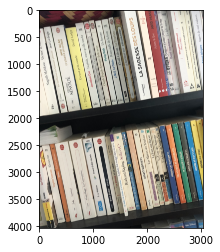

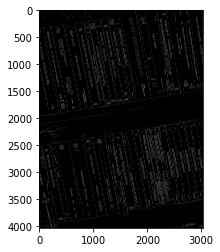

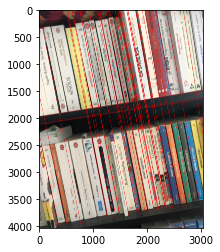

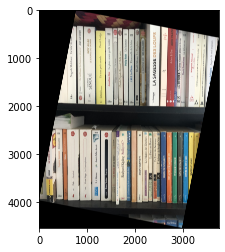

In [95]:
''' bookshelf orientation '''

# constraint : the majority of the books must be well oriented

# image load
img = Image.open('../image/img20.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img)

"""
img : image of an askew bookshelf
return : reoriented image
"""
def bookshelfOrientation(img):
    
    width, height = img.size
    img = np.array(img)
    
    # canny filter
    edges = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(edges, 50, 150)
    plt.imshow(edges, cmap='gray')
    plt.show()  

    # hough transform
    treshold = 500
    lines = cv2.HoughLines(edges, 1, np.pi/180, treshold)
    length = max(width, height)
    angles = []
    houghTransform = img.copy()
    for line in lines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + length*(-b))
            y1 = int(y0 + length*(a))
            x2 = int(x0 - length*(-b))
            y2 = int(y0 - length*(a))
        
            houghTransform = cv2.line(houghTransform, (x1,y1), (x2,y2), (255,0,0), 3)
            angles.append(theta)

    plt.imshow(houghTransform)
    plt.show()
    
    # orientation
    angles.sort()
    theta = angles[len(angles)//2]
    theta = math.degrees(theta)
    if theta>90:
        theta = theta - 180
    img = Image.fromarray(img, 'RGB')
    img = img.rotate(theta, expand = 1)
    
    return img

# show result
img = bookshelfOrientation(img)
plt.imshow(img)
plt.show()

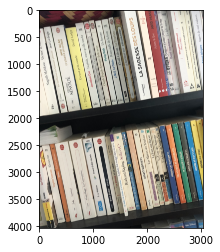

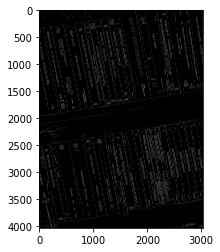

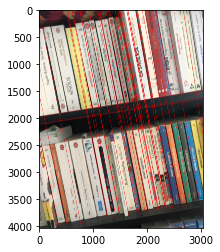

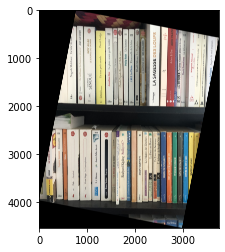

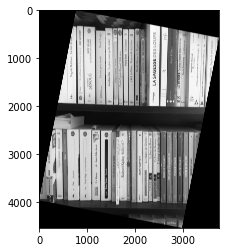

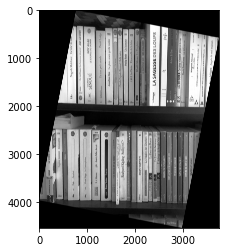

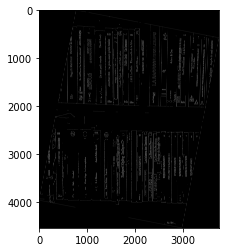

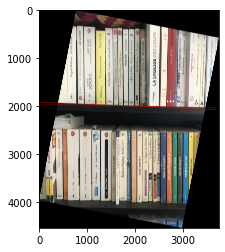

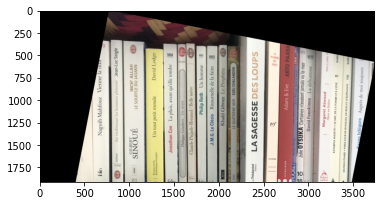

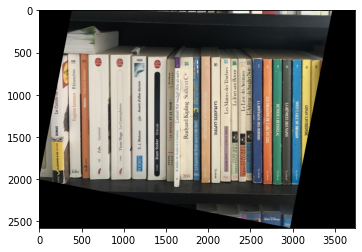

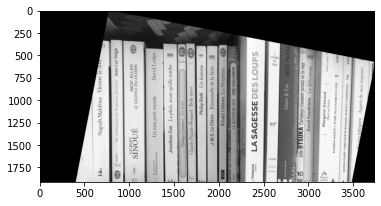

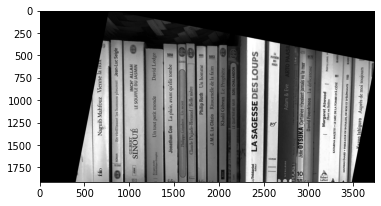

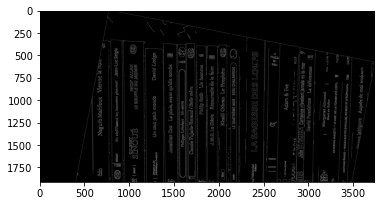

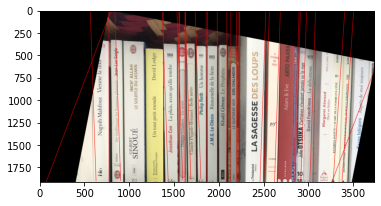

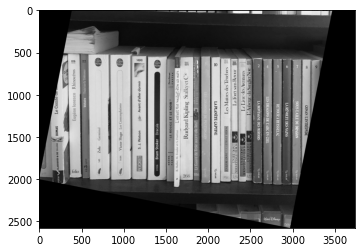

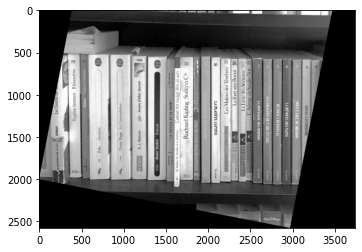

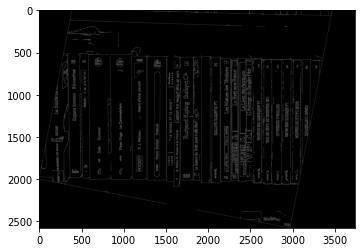

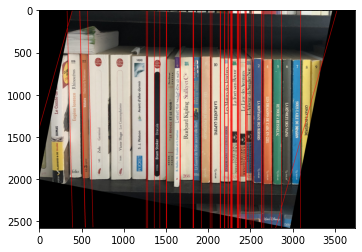

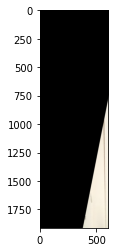

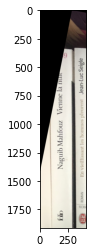

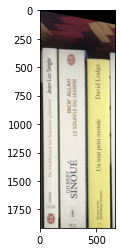

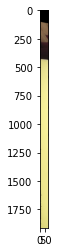

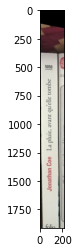

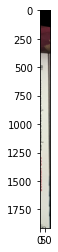

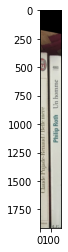

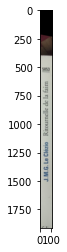

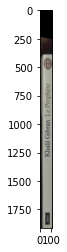

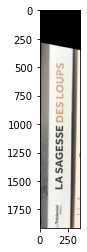

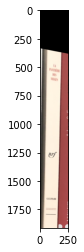

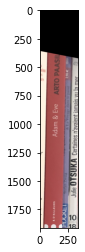

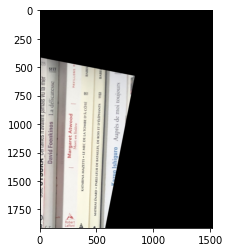

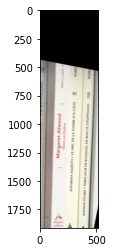

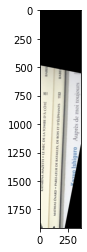

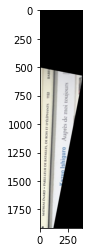

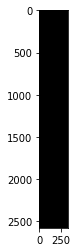

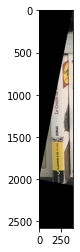

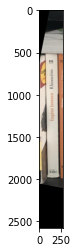

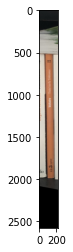

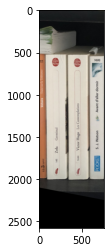

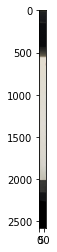

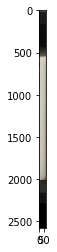

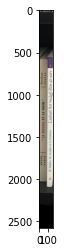

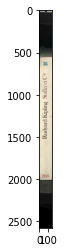

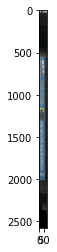

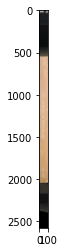

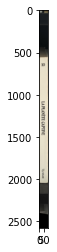

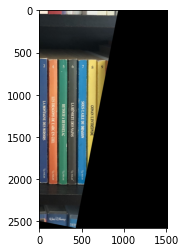

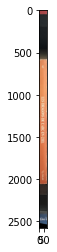

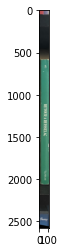

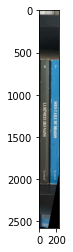

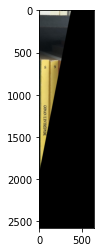

In [96]:
''' all process '''

# image load
img = Image.open('../image/img20.jpg')
plt.imshow(img)
plt.show()

# noise reducer
img = noiseReducer(img)

# orientation
reoriented = bookshelfOrientation(img)
plt.imshow(reoriented)
plt.show()

# bookshelf segmentation
rows = bookshelfSegmentation(reoriented)
for im in rows:
    plt.imshow(im)
    plt.show()

# row segmentation
books = []
for im in rows:
    spines = rowSegmentation(im)
    books = books + spines
for book in books:
    plt.imshow(book)
    plt.show()

# text extraction